Data exploration (raw data)
================

This is a small exploration of the data to justify the preprocessing applied.

We divide the external risk by the population of the destination. This is done in order to be able to compare data from different province's. It intuitively makes sense because, if 200 infected people arrive, it will be less important in the incidence (which is a relative variable) if the province has 500K than 10K habitants.

The external risk for a pronvince $i$ is then:

$R_i =  \frac{1}{P_i} \sum_{j}^{N} F_{ji} I_j$

where:
* $P_i$ is the population of the province $i$
* $N$ is the number of provinces with flux towards $i$
* $F_{jk}$ is the flux from province $j$ to province $i$
* $I_j$ is the incidence at province $j$

In [1]:
# Local imports
import pathlib
import sys
sys.path.insert(0, str(pathlib.Path.cwd().parent / 'src'))

from paths import PATHS
from data.base import get_data

In [2]:
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv(
    PATHS.rawdir / "provinces-incidence-mobility.csv",
    header=[0, 1]
)
df = df.fillna(0)

# Format column names correctly
for i, col in enumerate(df.columns.levels):
    new = np.where(col.str.contains('Unnamed'), '', col)
    df = df.rename(columns=dict(zip(col, new)), level=i)

# Load density/population data
prov_path = PATHS.rawdir / 'prov_data.xls'
prov_data = pd.read_excel(prov_path, dtype={'Provincia': 'string'})
den_map = dict(zip(prov_data.Provincia, prov_data.Densidad))
pop_map = dict(zip(prov_data.Provincia, prov_data.Poblacion))

# Process provinces
new_df = []
provinces = df[('province', '')].unique()
for p in provinces:

    dfp = df[df[('province', '')] == p]

    new_dfp = dfp[['date', 'province', 'incidence 7', 'flux intra']]
    new_dfp = new_dfp.droplevel(1, axis='columns')

    # Add external risk
    flux = dfp.xs('flux', level=1, drop_level=True, axis='columns')
    inc = dfp.xs('incidence 7', level=1, drop_level=True, axis='columns')
    new_dfp['external risk'] = (flux * inc).sum(axis='columns', min_count=1)

    # Add province density
    # new_dfp['density'] = den_map[p]

    # Normalize external risk and flux_intra by population
    new_dfp['external risk'] = new_dfp['external risk'] / pop_map[p]
    # new_dfp['flux intra'] = new_dfp['flux intra'] / pop_map[p]

    # Append province to final df
    new_df.append(new_dfp)

df = pd.concat(new_df).reset_index(drop=True)
df = df.set_index(['date', 'province'])
df

,,incidence 7,flux intra,external risk
date,province,,,
2020-02-21,Albacete,0,951331002,35.179470
2020-02-22,Albacete,0,760491825,19.130062
2020-02-23,Albacete,0,646931003,28.780122
2020-02-24,Albacete,0,857782369,55.024169
2020-02-25,Albacete,0,885470089,87.204572
...,...,...,...,...
2021-03-05,Ávila,5,298761282,6419.753558
2021-03-06,Ávila,4,228098481,4587.355008
2021-03-07,Ávila,4,194500443,3013.072642


In [5]:
df.describe()

,incidence 7,flux intra,external risk
count,19914.000000,1.991400e+04,19914.000000
mean,99.499849,1.899128e+09,9971.793843
std,121.718055,2.570166e+09,14975.348330
min,0.000000,5.772144e+07,0.000000
25%,9.000000,5.528329e+08,683.874933
50%,58.000000,1.147899e+09,4303.060966
75%,144.000000,2.287500e+09,13044.467431
max,827.000000,2.115425e+10,180435.581847


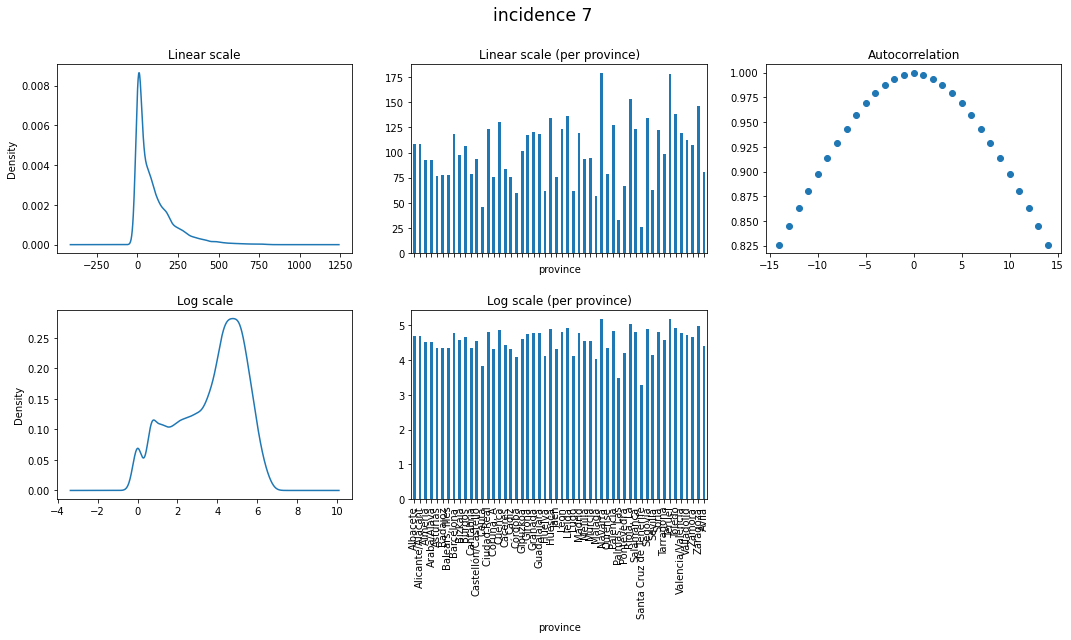

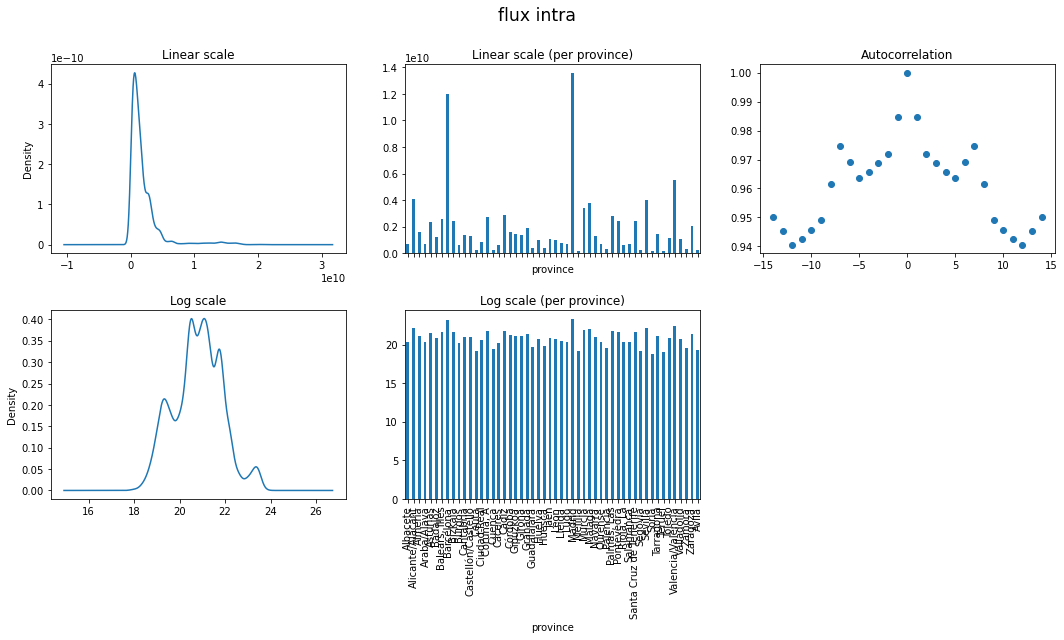

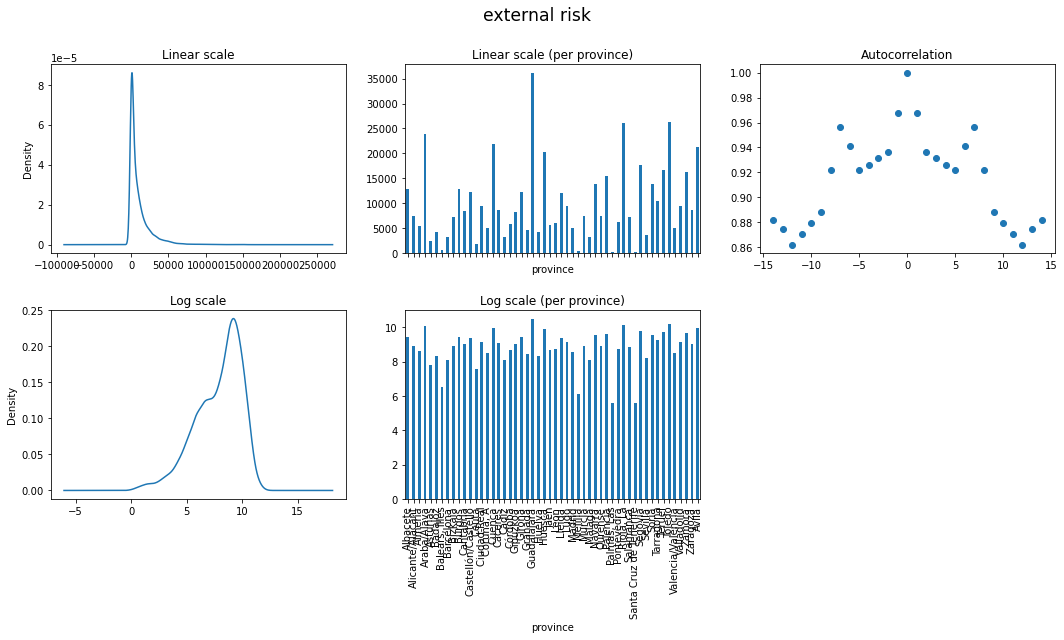

In [27]:
for c in df.columns:

    fig, axs = plt.subplots(2,3, figsize=(18,8))
    plt.subplots_adjust(hspace=0.3)

    fig.suptitle(c, size='xx-large')
    
    if df[c].min() == 0:
        df[c] += 1  # avoid 0 problem with log

    axs[0,0].set_title('Linear scale')
    df[c].plot.kde(ax=axs[0,0])

    axs[1,0].set_title('Log scale')
    np.log(df[c]).plot.kde(ax=axs[1,0])

    d = df[c].unstack().mean()

    axs[0,1].set_title('Linear scale (per province)')
    d.plot.bar(ax=axs[0,1])
    axs[0,1].set_xticklabels([])

    axs[1,1].set_title('Log scale (per province)')
    np.log(d).plot.bar(ax=axs[1,1])
    
    axs[0,2].set_title('Autocorrelation')
    axs[0,2].acorr(df[c] * 1.0, maxlags=14, usevlines=False)
    
    axs[1,2].axis('off')

In [36]:
# Check correlations
corr = df[df.columns[:-1]].corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,incidence 7,flux intra,external risk
incidence 7,1.000000,-0.014249,0.630289
flux intra,-0.014249,1.000000,-0.160342
external risk,0.630289,-0.160342,1.000000


# Conclusions

* Flux intra and external risk are divided by the population of the province
* The external risk should be log normalized
* The incidence should be log normalized
* From yhe autocorrelation plots, we can see that `flux intra` and `external risk` both have weekly periodicities as both are computed from mobility data (mobility is always high on weekdays and low on weekends). One can apply a 7-day rolling mean to all mobility data to remove this periodicity.

We should exclude the following provinces as outliers:
```
'Ceuta', 'Melilla', 'Balears, Illes', 'Santa Cruz de Tenerife', 'Palmas, Las' 
```